#Generative Model for Dirichlet Process Mixture of Gaussians

## Chris Krapu
####Advanced Machine Learning (STA571) 
####Duke University, Spring 2016

This IPython notebook shows how to implement a generative DPM-Gaussian model using numpy and scipy.stats. The inference for this model is not included in this document. For an already existing inference implementation, see the scikit team's [version](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.DPGMM.html) of variational inference applied to this problem  for more information.

To learn more about this subject, we refer the reader to a paper by Carl Rasmussen entitled "The Infinite Gaussian Mixture Model" which is accessible [here](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.DPGMM.html)

## Table of contents

1. Overview of DPMG
2. Code
3. Varying Hyperparameters
    * Degrees of freedom
    * Scale matrix trace
    * Scale matrix diagonality
    * $\lambda$

The Dirichlet process mixture of Gaussians (DPMG) generative model assumes that each data point in an n-dimensional space is generated by a multivariate normal distribution (MVN), and a few MVNs may be used to generate all the data. Then, by placing a prior on the hyperparameters of the MVNs, we can control their shared relationship in the data generating process. We use the normal-inverse Wishart (NIW) conjugate prior to create a mean and covariance matrix for each MVN component, which is then used to generate the data. The MVN component used for each data point is identified by a label drawn according to a Chinese restaurant process or GEM construction. The latter is used in this notebook. The GEM allows for a potentially infinite number of MVN components generating our data. In practice, we restrict this by ignoring any components that have a sufficiently low probability of getting chosen to generate a data point. 

The plate diagram below shows how the hyperparameters of $\alpha$, $\Psi$, $\mu_0$ and $\lambda$ feed into the distributions used.

<img src="dgmm_diagram2.png">

#Code

To do the sampling, we specify two functions: GEM(alpha) makes draws from the stick-breaking construction of the DPM and gives us back a probability distribution defined over the number of  mixture components that we wish our DPMG to have. Then, we use that distribution along with some other parameters passed into sample_DPMG which makes 1) draws of the multivariate normal (MVN) parameters given the normal-inverse Wishart (NIW) hyperparameters, 2) draws of the mixture label $z_n$ given the probability distribution provided by the GEM, and 3) draws of the data points $x_n$ in feature space given the mixture labels and the MVN parameters for each mixture component. For the beta, MVN, categorical (a.k.a. "choice"), and inverse-Wishart draws, we use out-of-the-box functionality from numpy and scipy. Only the GEM draws are coded by hand in this notebook. Finally, Matplotlib is used to generate the plots shown later.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import beta, choice
from scipy.stats import  invwishart, multivariate_normal

%matplotlib inline

In [9]:
def GEM(alpha,cutoff_probability = 1e-4):
    """This function implements the stick-breaking distribution, aka the GEM distribution 
        which underlies the Dirichlet process mixture.
    
        Arguments:
            
        alpha              - (float) concentration parameter which should be set high to induce a higher-dimensional distribution 
        
        cutoff_probability - (float) minimum probability which a distributional component is allowed to have.
                             Once a component with this probability has been seen, the function terminates
        
        Returns:
        
        distribution        - (numpy 1D array of floats) a probability distribution which adds up to one.
    """
    distribution      =  []
    last_atom_mass    = 1.0
    total_mass_drawn= 0
    
    while last_atom_mass > cutoff_probability:
        
        # First, we break off a portion of the remaining probability mass
        current_atom_mass = beta(1,alpha) * (1.0 - total_mass_drawn)
        
        # Then we tabulate how much we used on this draw, so that the next draw will be appropriately rescaled.
        total_mass_drawn += current_atom_mass
        last_atom_mass    = current_atom_mass
        
        distribution.append(current_atom_mass)
        
        
        
    distribution = np.asarray(distribution)    
    return distribution / np.sum(distribution)
    

In [10]:
def sample_DPMG(GEM_parameters,NIW_parameters,number_samples):
    """This function generates draws from a Dirichlet process mixture of Gaussians (DPMG).
    
        Arguments:
            
        GEM_parameters - dict of {string:floats} which control the arguments passed into the GEM function
                
        NIW_parameters - dict of {string:floats} parameterizing the normal-inverse Wishart conjugate prior on the multivariate normal
        
        number_samples - integer number of draws made from the DPMG
        
        Returns:
        
        x              - numpy n-D array of n-dimensional data points, where n is implictly specified by the hyperparameter inputs to the NIW 
        
        z              - numpy 1D array of integers identifying the mixture component each x point belongs to, i.e. a latent variable in practice
    """
    alpha   = GEM_parameters['alpha']
    cutoff  = GEM_parameters['probability_cutoff']
    
    psi     = NIW_parameters['psi']
    nu      = NIW_parameters['nu']
    mu_0    = NIW_parameters['mu']
    l       = NIW_parameters['lambda']
    
    dimensions = len(mu_0)
    
    pi_k = GEM(alpha,cutoff)
    
    K = len(pi_k)
    
    sigma_k = invwishart.rvs(nu,psi,size=K)
    
    
    # As the NIW uses the covariance matrix sigma as the covariance for the mean draws, we must make sure that we use the right sigma_k 
    # entry to generate the mu_k
    mu_k = []
    for sigma in sigma_k:
        mu_k.append(multivariate_normal.rvs(mean=mu_0,cov=(1.0/l)*sigma))
    
    
    x = np.zeros([number_samples,dimensions])
    
    mixture_components_k = range(0,K)
    
    # We can draw all of our mixture component labels at once with the choice function.
    z = choice(mixture_components_k,size=number_samples,p=pi_k)
    
    # Unfortunately, no such function is available for drawing the actual feature-space values, and so we must iterate over each point.
    for n in range(0,number_samples):
        x[n,:] = multivariate_normal.rvs(mean=mu_k[z[n]],cov=sigma_k[z[n]])
 
    return x,z
        
        
    
    
        
    

# Varying Hyperparameters

## Varying the degree-of-freedom hyperparameter for the NIW prior

We'd like to know how the distribution of our draws changes as we vary the hyperparamters of the NIW prior on the MVN components. In the next code cell and the following figure, we will allow the value of $\nu$ to vary over a wide range of values. The horizontal axis of the subplots indicates increasing $\nu$, while the vertical axis corresponds to different random draws and does not imply an ordering of any sort.

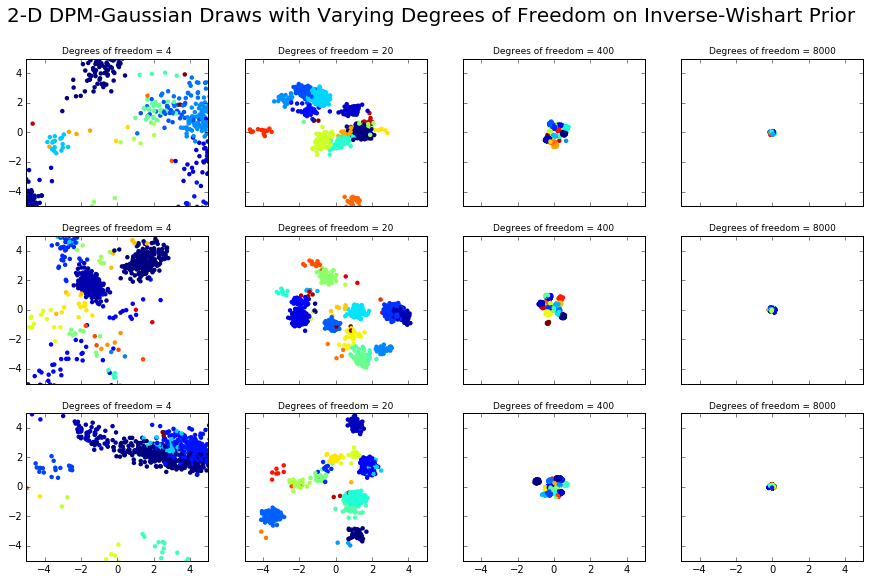

In [11]:
output_dimensions = 2

GEM_parameters = {}
GEM_parameters['alpha'] = 5
GEM_parameters['probability_cutoff'] = 1e-4


NIW_parameters ={}
NIW_parameters['psi'] = np.asarray([[1,0],[0,1]])
NIW_parameters['nu'] = output_dimensions
NIW_parameters['mu'] = np.zeros(output_dimensions)
NIW_parameters['lambda'] = 0.02


number_samples = 1000


dof_multiplier = [2,10,200,4000]

fig,ax = plt.subplots(3,len(dof_multiplier),figsize=(15,9),sharey=True,sharex=True)

for i in range(0,3):
    for j in range(0,len(dof_multiplier)):
        NIW_parameters['nu'] = output_dimensions * dof_multiplier[j]
        draws,labels = sample_DPMG(GEM_parameters,NIW_parameters,number_samples)
        ax[i,j].scatter(draws[:,0],draws[:,1],c=labels,edgecolors='none')
        ax[i,j].set_xlim([-5,5])
        ax[i,j].set_ylim([-5,5])
        ax[i,j].set_title('Degrees of freedom = '+str(dof_multiplier[j]*2),fontsize=9)

_ = plt.suptitle("2-D DPM-Gaussian Draws with Varying Degrees of Freedom on Inverse-Wishart Prior",fontsize = 20)




As we can see from the figure above, increasing the value of $\nu$ reduces the dispersion in feature space. Setting $\nu$ to be a large value penalizes the probability of matrices with large determinants because the PDF of the sampled matrices $X$ can be written as the following:

$$P(X) \propto |X|^{-(\frac{-\nu+p+1}{2})}$$

Since covariance matrices allowing for more dispersion typically have larger determinants, the covariance matrix draws will become 'smaller' as we increase $\nu$, in the sense that the determinant reflects the 'size' of the matrices' transformations.

## Varying the trace of the scale matrix 

If we assume that the hyperparameter $\Psi$ is diagonal (a very strong condition) then we can vary the value of its trace and see what the response is. Somewhat unsurprisingly, it is similar to varying the degree of freedom in this case because the resulting covariance matrix draws are mostly isotropic. Since the NIW prior has a term which depends on $X$ such that $P(X) \propto e^{-\frac{1}{2}tr(\Psi X^{-1})}$, it makes sense that matrices with large traces become more probable as the PDF is proportional to the trace of $X^{-1}$.

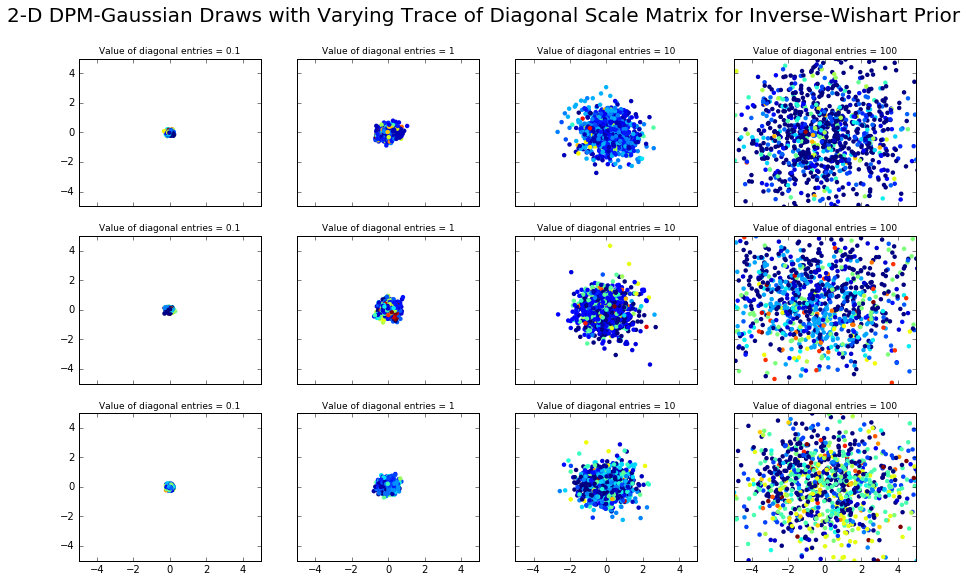

In [12]:
scale_multiplier = [0.1,1,10,100]

fig,ax = plt.subplots(3,len(scale_multiplier),figsize=(15,9),sharey=True,sharex=True)

for i in range(0,3):
    for j in range(0,len(scale_multiplier)):
        NIW_parameters['nu'] = output_dimensions * 10
        NIW_parameters['psi'] = np.asarray([[1,0],[0,1]]) * scale_multiplier[j]
        NIW_parameters['lambda'] = 10
        draws,labels = sample_DPMG(GEM_parameters,NIW_parameters,number_samples)
        ax[i,j].scatter(draws[:,0],draws[:,1],c=labels,edgecolors='None')
        ax[i,j].set_xlim([-5,5])
        ax[i,j].set_ylim([-5,5])
        ax[i,j].set_title('Value of diagonal entries = '+str(scale_multiplier[j]),fontsize=9)

_ = plt.suptitle("2-D DPM-Gaussian Draws with Varying Trace of Diagonal Scale Matrix for Inverse-Wishart Prior",fontsize = 20)

## Varying the character of the $\Psi$ matrix

The next thing that we'll do is see what happens as we allow $\Psi$ to change from a matrix which is less diagonal to one which is more diagonal. We'll consider $\Psi$ to be the linear combination of a matrix of all 1s ($\textbf{1}$) and the identity matrix $\textbf{I}$:

$$\Psi = a \textbf{1} + (1-a) \textbf{I}$$

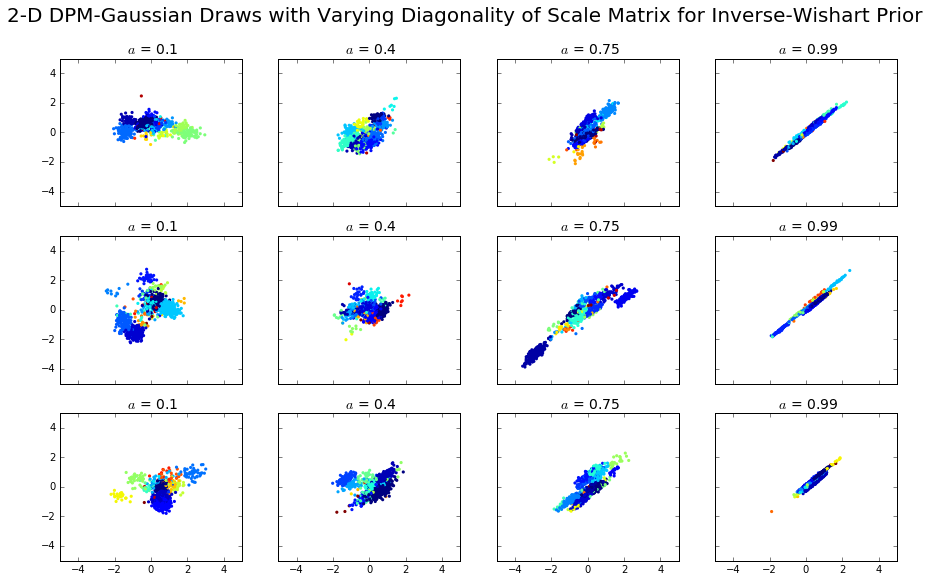

In [13]:
modifiers = [0.1,0.40,0.75,0.99]

fig,ax = plt.subplots(3,len(modifiers),figsize=(15,9),sharey=True,sharex=True)

for i in range(0,3):
    for j,a in enumerate(modifiers):
        NIW_parameters['nu'] = output_dimensions * 10
        NIW_parameters['psi'] = a*np.ones([2,2]) + (1-a) *np.eye(2)
        NIW_parameters['lambda'] = 0.1
               
        draws,labels = sample_DPMG(GEM_parameters,NIW_parameters,number_samples)
        ax[i,j].scatter(draws[:,0],draws[:,1],c=labels,s=10,edgecolors='None')
        ax[i,j].set_xlim([-5,5])
        ax[i,j].set_ylim([-5,5])
        ax[i,j].set_title(' $a$ = ' + str( a),fontsize=14)

_ = plt.suptitle("2-D DPM-Gaussian Draws with Varying Diagonality of Scale Matrix for Inverse-Wishart Prior",fontsize = 20)

As our scale matrix hyperparameter becomes more and more diagonal, it penalizes the sample covariance matrix $X$ more and more for having off-diagonal covariance terms. In the extreme scenario of the scale matrix being nearly entire diagonal, there exists very little probability mass assigned to covariance matrix draws which are not diagonal and hence the resulting data is confined to a  very narrow axis. 

##Varying $\lambda$

Our last hyperparameter is $\lambda$, which links our IW covariance matrix draw to the covariance matrix hyperparameter for the MVN prior placed on our component means. When $\lambda$ is set to be very low, the determinant or 'size' of the covariance matrix used to generate our component means will become much larger and hence the data clusters will be more spread apart from each other.

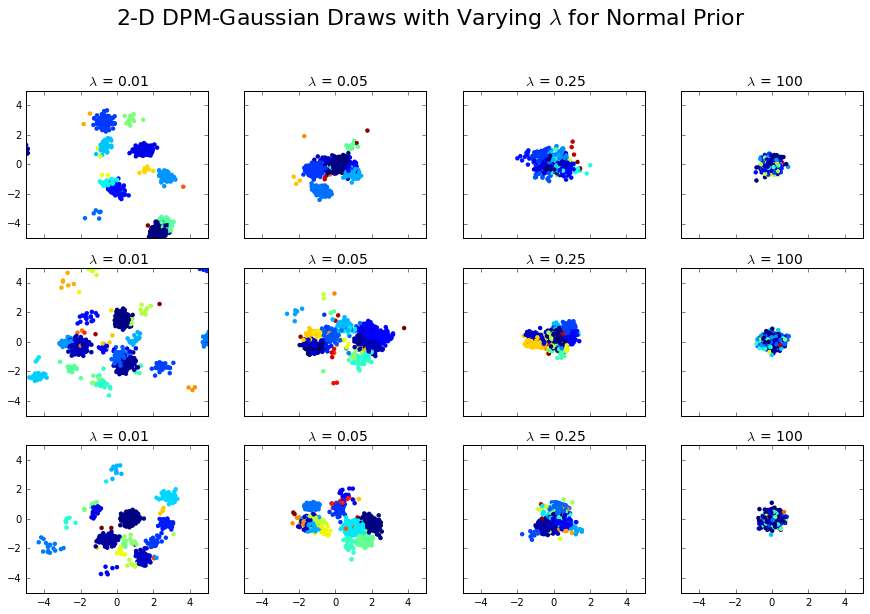

In [14]:
modifiers = [0.01,0.05,0.25,100]

fig,ax = plt.subplots(3,len(modifiers),figsize=(15,9),sharey=True,sharex=True)

for i in range(0,3):
    for j,l in enumerate(modifiers):
        NIW_parameters['lambda'] = l
        NIW_parameters['nu'] = output_dimensions * 10
        NIW_parameters['psi'] = np.eye(2)
               
        draws,labels = sample_DPMG(GEM_parameters,NIW_parameters,number_samples)
        ax[i,j].scatter(draws[:,0],draws[:,1],c=labels,edgecolors='None')
        ax[i,j].set_xlim([-5,5])
        ax[i,j].set_ylim([-5,5])
        ax[i,j].set_title(' $\lambda$ = ' + str(l),fontsize=14)

_ = plt.suptitle("2-D DPM-Gaussian Draws with Varying $\lambda$ for Normal Prior",fontsize = 22,y=1.03)